In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import ClimateVR
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
gray_a = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA']
green_a = ['NEE', 'FSLR', 'VWDRY', 'BEP']
assets = gray_a + green_a
benchmark = '^GSPC'
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
e_eco_data = pd.merge(economic_data, climate_data, on='Date').iloc[:-1]

gray_data = all_data[gray_a]  
green_data = all_data[green_a]
all_data.drop('Date', axis=1, inplace=True)
e_eco_data.drop('Date', axis=1, inplace=True)


[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Instanciar el modelo ClimateVR con los datos
vr_model = ClimateVR(e_eco_data)

# Optimizar el número de retardos usando Optuna
optimal_maxlags, optimal_rmse = vr_model.optimize_maxlags(all_data=e_eco_data, n_trials=100)
print(f'Número óptimo de retardos: {optimal_maxlags}')
print(f'RMSE óptimo: {optimal_rmse}')

# Ajustar el modelo VR con el número óptimo de retardos
vr_results = vr_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = vr_model.predict(vr_results, lags=optimal_maxlags, end=len(e_eco_data))

Número óptimo de retardos: 12
RMSE óptimo: 9423.656071171024


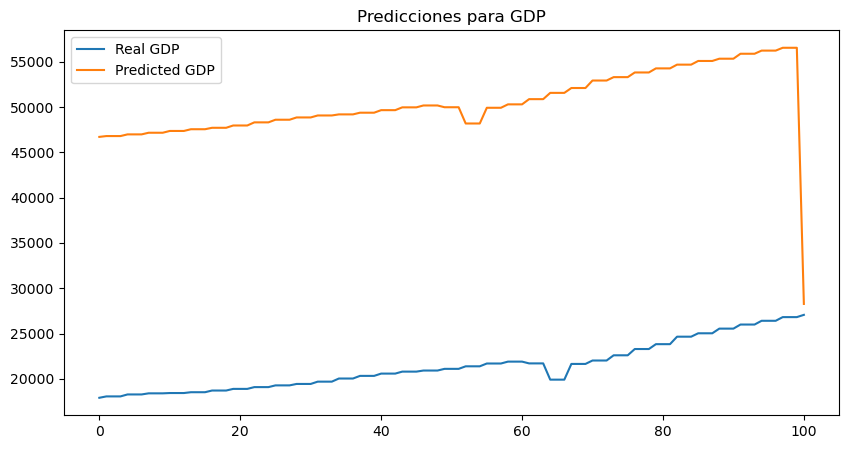

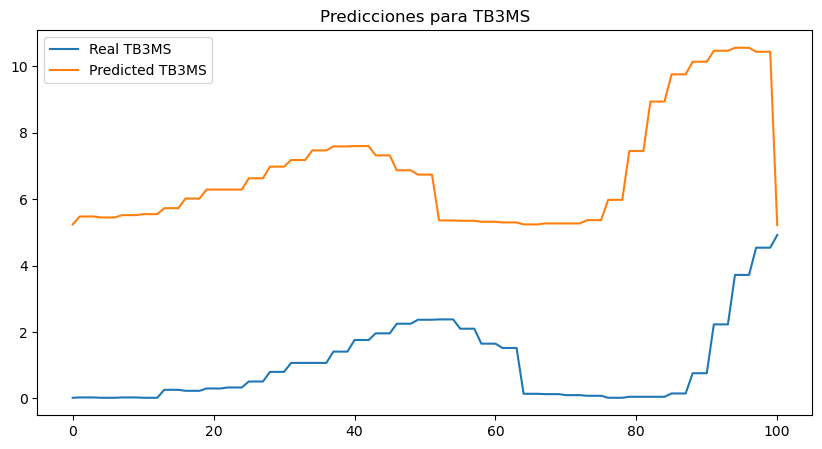

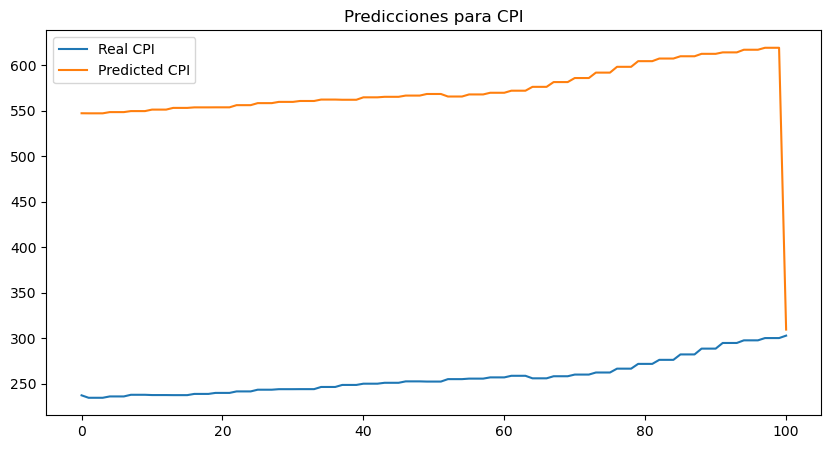

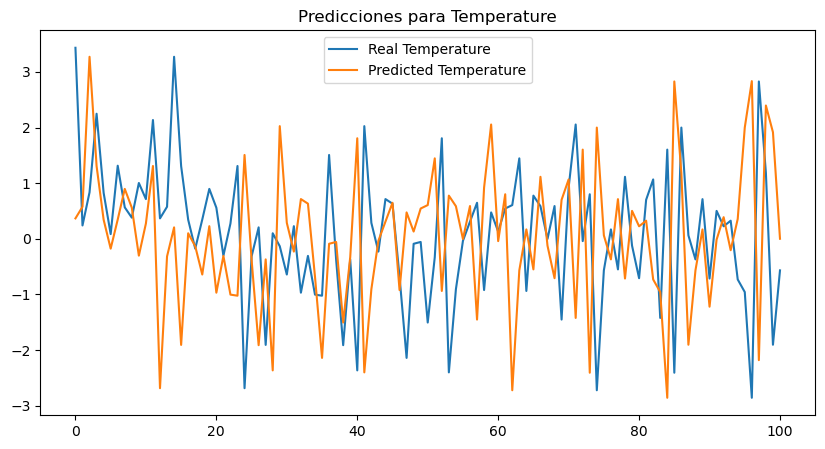

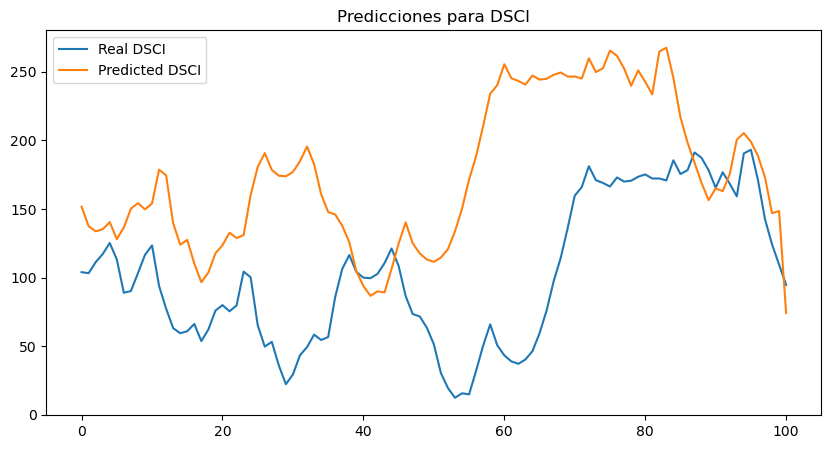

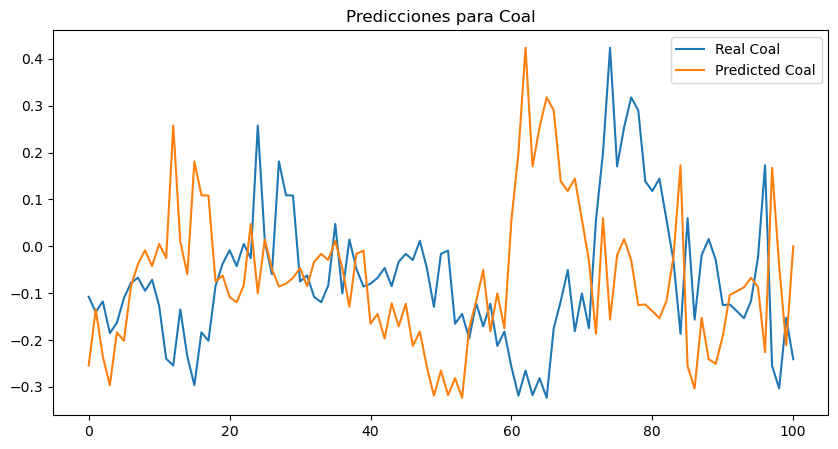

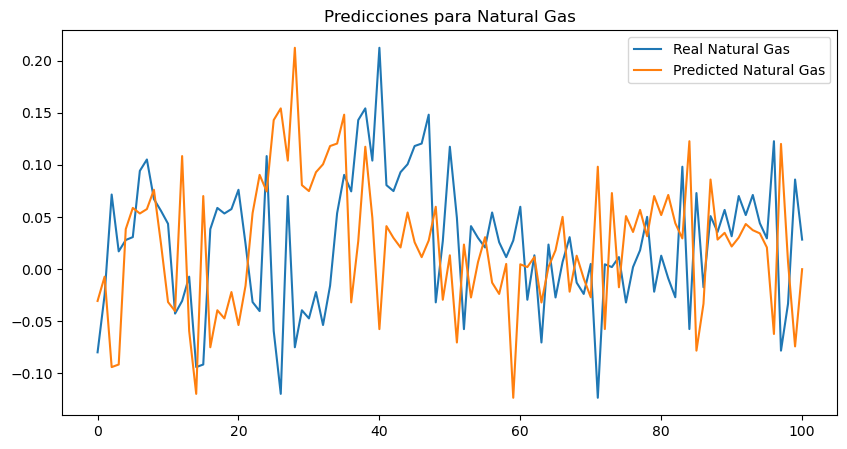

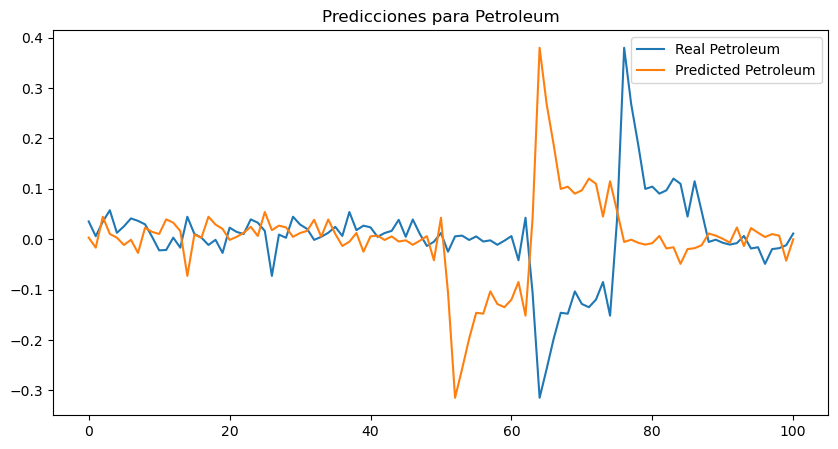

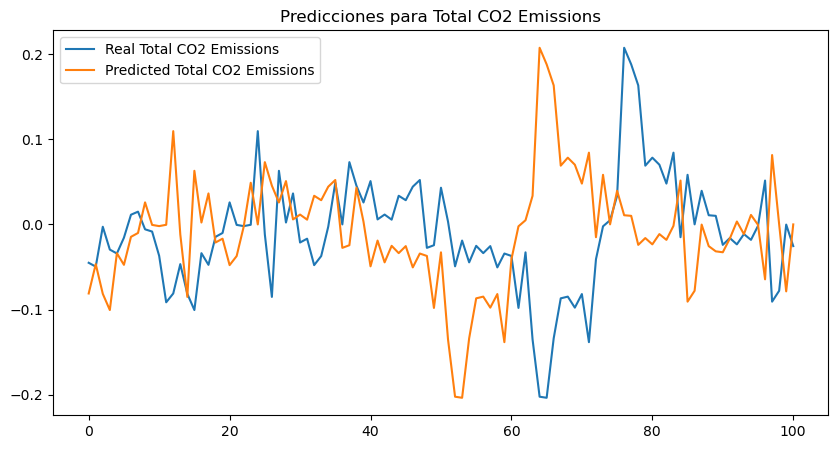

In [4]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(e_eco_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(e_eco_data.index[:len(predict)], e_eco_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(e_eco_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

Escenarios generados correctamente.


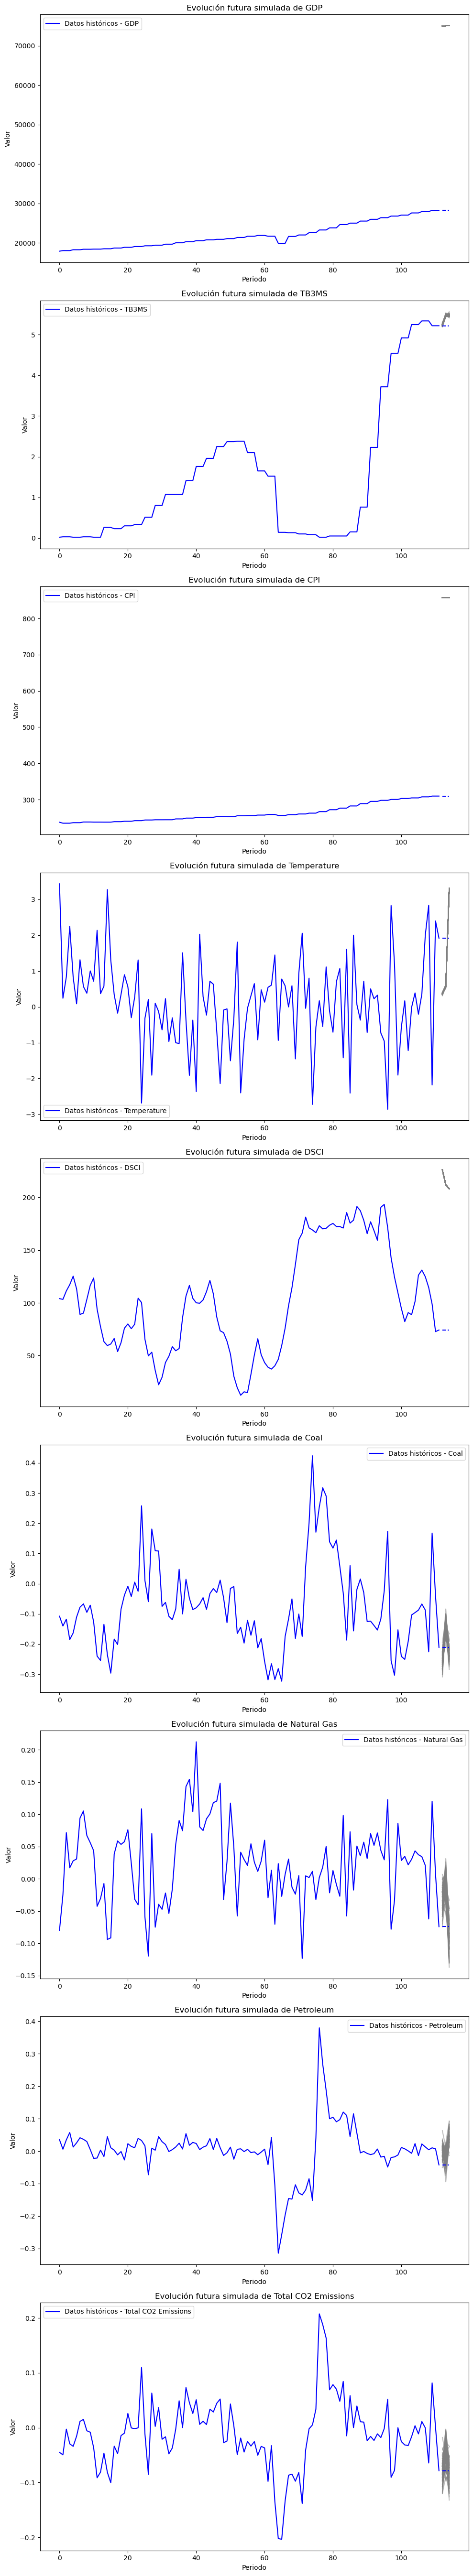

In [5]:
# Generar 100 escenarios para los próximos 3 periodos
scenarios = vr_model.simulate_scenarios(vr_results, lags=optimal_maxlags, n_scenarios=100, periods=3, noise_std=0.02)

# Ajuste especial para variables acumulativas como GDP, CPI y DSCI
for var_idx, var_name in enumerate(vr_model.endog.columns):
    if var_name in ['GDP', 'CPI', 'DSCI']:  # Si la columna es GDP, CPI o DSCI
        # Obtener el último valor conocido en la serie histórica
        last_known_value = vr_model.endog.iloc[-1, var_idx]
        for scenario in range(100):
            # Asegurarse de que las predicciones se acumulen sobre el último valor conocido
            scenarios[var_name][:, scenario] += last_known_value

# Verificar si los escenarios fueron generados correctamente
if scenarios:
    print("Escenarios generados correctamente.")
else:
    print("Error: No se generaron escenarios.")

# Graficar los resultados para cada variable no financiera, incluyendo datos históricos
n_variables = vr_model.neqs
fig, axs = plt.subplots(n_variables, 1, figsize=(10, 6 * n_variables))

for var_idx, var_name in enumerate(vr_model.endog.columns):
    
    # Graficar datos históricos
    axs[var_idx].plot(vr_model.endog.index, vr_model.endog.iloc[:, var_idx], label=f'Datos históricos - {var_name}', color='blue')

    # Crear un índice para los 3 periodos futuros (continuando desde los datos históricos)
    future_index = range(len(vr_model.endog), len(vr_model.endog) + 3)
    
    # Graficar escenarios futuros para los próximos 3 periodos
    for scenario in range(100):
        try:
            axs[var_idx].plot(future_index, scenarios[var_name][:, scenario], color='gray', alpha=0.5)
        except Exception as e:
            print(f"Error al graficar la variable {var_name}: {e}")
    
    # Mantener la continuidad en las líneas, asegurando que se conecten suavemente desde el último valor histórico
    axs[var_idx].plot(future_index, [vr_model.endog.iloc[-1, var_idx]]*3, color='blue', linestyle='--')  # Línea para continuidad
    
    axs[var_idx].set_title(f'Evolución futura simulada de {var_name}')
    axs[var_idx].set_xlabel('Periodo')
    axs[var_idx].set_ylabel('Valor')
    axs[var_idx].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Instanciar la clase ScenarioDICE
scenario_dice = ScenarioDICE()

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

In [7]:
optimizer = PortfolioOptimizer(
    asset_prices=asset_prices,
    risk_free_rate=rf,
    benchmark_prices=benchmark_prices
)

optimal_portfolios, portfolios_df = optimizer.optimize_with_multiple_strategies(
    strategies=['sharpe', 'omega', 'sortino'],
    gray_assets=gray_a,
    green_assets=green_a
)

portfolios_df

,weights,metric_score,strategy,green_weight,gray_weight
0,"[0.0, 2.8449465006019636e-16, 0.74999999999999...",-0.244906,sharpe,0.75,0.25
1,"[0.06603783223678487, 0.0361266722034251, 0.21...",-0.337795,sharpe,0.75,0.25
2,"[0.1247396571153519, 0.001036622609221192, 0.2...",-0.338690,sharpe,0.75,0.25
3,"[0.02110391940889611, 0.001073902044829461, 0....",-0.361179,sharpe,0.75,0.25
4,"[0.07049315401915666, 0.0043998958937698065, 0...",-0.386052,sharpe,0.75,0.25
5,"[0.51256877946837, 3.518164484894262e-09, 0.14...",2.786205,omega,0.75,0.25
6,"[0.166289083206787, 0.003927363362500617, 0.02...",3.150358,omega,0.75,0.25
7,"[0.03522435903974426, 0.1266300377628755, 0.00...",3.143809,omega,0.75,0.25
8,"[0.06227048155453042, 0.02279675550008584, 0.0...",3.141844,omega,0.75,0.25
9,"[0.12526977562015557, 0.1267846993964037, 0.03...",3.105184,omega,0.75,0.25


In [ ]:
# Buscar el portafolio con el mejor score
best_portfolio = portfolios_df.loc[portfolios_df['score'].idxmax()]

# Calcular el retorno promedio del mejor portafolio
average_return = np.mean(best_portfolio['adjusted_return'])

# Imprimir el mejor portafolio con su retorno promedio
print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")
best_portfolio
